# NDVI Time Series Analysis with OpenEO

This notebook demonstrates how to extract and analyze Normalized Difference Vegetation Index (NDVI) time series for agricultural parcels using Sentinel-2 imagery and the OpenEO API.

## Overview

In this notebook, we will:
1. Connect to an OpenEO backend service
2. Define agricultural field geometries 
3. Load Sentinel-2 imagery for a specific time period
4. Calculate NDVI from red and near-infrared bands
5. Extract time series data by aggregating NDVI values over field geometries
6. Visualize and analyze the resulting time series

## What is NDVI?

The Normalized Difference Vegetation Index (NDVI) is a simple but effective index for quantifying vegetation greenness. It uses the contrast between the red and near-infrared reflectance of vegetation.

NDVI is calculated as: (NIR - Red) / (NIR + Red)

NDVI values range from -1 to 1:
- Values around 0 typically represent non-vegetated areas (water, bare soil, buildings)
- Values between 0.2 and 0.4 represent sparse vegetation
- Values between 0.4 and 0.8 represent dense vegetation (higher values indicate healthier vegetation)

NDVI time series are valuable for monitoring crop growth, detecting anomalies, and analyzing seasonal patterns.

## Import Required Libraries

We begin by importing the necessary Python libraries for data processing and visualization.

In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt


## Connect to OpenEO Backend

Connect to a local OpenEO backend running on port 8081 and authenticate using OpenID Connect.

In [2]:
import openeo
connection = openeo.connect(url="https://openeo.ds.io").authenticate_oidc_authorization_code()

## Define Field Geometries

Below we define four agricultural field geometries as GeoJSON Polygons. These fields will be used to extract NDVI time series. The coordinates are in WGS84 (EPSG:4326) and represent fields near latitude 51.22° N, longitude 5.06° E (likely in the Netherlands or Belgium).

In [3]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.055945487931457, 51.222709834076504], [5.064972484168688, 51.221122565090525], [5.064972484168688, 51.221122565090525], [5.067474954083448, 51.218249806779134], [5.064827929485983, 51.21689628072789], [5.05917785594747, 51.217191909908095], [5.053553857094518, 51.21807492332223], [5.055945487931457, 51.222709834076504]]]}},
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.063345886679116, 51.23087606640057], [5.06604742694687, 51.22886710731809], [5.070627820472246, 51.22874440121892], [5.068403609708207, 51.22657208381529], [5.064823257492447, 51.22676051738515], [5.064892324615199, 51.2283032878514], [5.063641745941974, 51.2285757299238], [5.062340811262595, 51.227722351687945], [5.06076005158084, 51.228042312276536], [5.063345886679116, 51.23087606640057]]]}},
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.07163184674986, 51.23481147556147], [5.076706025697324, 51.23317590781036], [5.077828303041866, 51.233226237184724], [5.078024733866917, 51.23263978271262], [5.080771081607657, 51.23259097170763], [5.083734842574312, 51.23530464074437], [5.080957826735458, 51.23646091560258], [5.079752631651647, 51.23519531038643], [5.077238400183506, 51.23490534677628], [5.072856439300575, 51.23593546777778], [5.07163184674986, 51.23481147556147]]]}},
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.083897244679042, 51.23510639883143], [5.081302408741335, 51.232922477780846], [5.082963802194108, 51.233146058575876], [5.084497702305552, 51.232672717580655], [5.085732850338428, 51.2340852086282], [5.083897244679042, 51.23510639883143]]]}}
    ]}
"""
)

## Load Sentinel-2 Data and Calculate NDVI

Here we load Sentinel-2 L2A data for a 2-month period (June-August 2020) covering our area of interest. We select only the red (B04) and near-infrared (B08) bands at 10m resolution, as these are needed for NDVI calculation.

The spatial extent is defined to cover all our field geometries with a small buffer.

In [4]:
s2cube = connection.load_collection(
    "sentinel-2-l2a",
    temporal_extent=["2020-04-01", "2020-10-01"],
    spatial_extent={"west": 5.05, "south": 51.21, "east": 5.09, "north": 51.24},
    bands=["B04_10m", "B08_10m"],
    max_cloud_cover=20,
)

# Extract individual bands
red = s2cube.band("B04_10m")
nir = s2cube.band("B08_10m")

# Calculate NDVI using the formula: (NIR - Red) / (NIR + Red)
ndvi = (nir - red) / (nir + red)

/home/emathot/Workspace/DevelopmentSeed/titiler-openeo/.venv/lib/python3.10/site-packages/openeo/rest/connection.py:1140: UserWarning: sentinel-2-l2a property filtering with properties that are undefined in the collection metadata (summaries): eo:cloud_cover.
  return DataCube.load_collection(


## Extract Time Series for Each Field

Now we aggregate the NDVI values spatially for each field geometry using the mean as our reducer function. This gives us the average NDVI value within each field for each available date in our time period.

The result is a time series of NDVI values for each field.

In [5]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

## Download and Preview Time Series Data

We download the time series data as a CSV file and preview the first few rows to understand its structure.

In [6]:
timeseries.download("timeseries-basic.csv", format="csv")
pd.read_csv("timeseries-basic.csv", index_col=0).head()

,feature_index,value
date,,
2020-09-22T10:46:49.025Z,0,0.426953
2020-09-19T10:36:49.024Z,0,0.423887
2020-09-17T10:50:31.024Z,0,0.420011
2020-09-14T10:40:31.024Z,0,0.395836
2020-09-12T10:46:29.024Z,0,0.376717


## Visualize Time Series

This function helps us visualize the NDVI time series for all fields. The plot shows the temporal evolution of NDVI for each field, allowing us to compare vegetation growth patterns between fields.

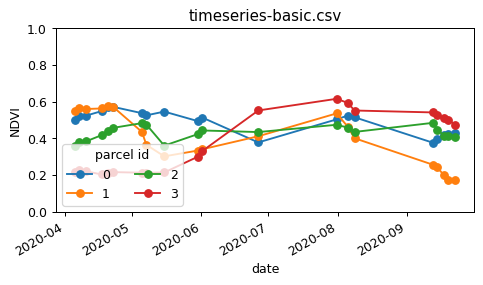

In [7]:
def plot_timeseries(filename, figsize=(6, 3)):
    """Plot NDVI time series from a CSV file

    Parameters:
    ----------
    filename : str
        Path to the CSV file containing time series data
    figsize : tuple, optional
        Figure size as (width, height) in inches
    """
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)  # Convert index to datetime format

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["value"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)  # NDVI typically ranges from 0 to 1 for vegetation
    ax.legend(title="parcel id", loc="lower left", ncol=2)


plot_timeseries("timeseries-basic.csv")

## Conclusion

This notebook demonstrates a complete workflow for extracting and analyzing NDVI time series from Sentinel-2 imagery using OpenEO. The approach can be extended to:

- Analyze longer time periods to study seasonal patterns
- Include additional vegetation indices beyond NDVI
- Apply filtering or smoothing to handle noise in the time series
- Implement anomaly detection to identify unusual growth patterns
- Extract growth parameters such as start of season, peak of season, etc.

NDVI time series analysis is valuable for a range of applications including crop monitoring, yield estimation, drought assessment, and phenological studies.